In [1]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

In [2]:
def generate_sequence(c=0.005, f_0=0):
    """
    Generate a linear chirp signal. x is the time-domain signal and f is the instantaneous frequency
    """
    t = np.arange(0, 50, 0.1)
    f = c * t + f_0
    phi = 2 * np.pi * (c / 2 * t**2 + f_0 * t)
    x = np.sin(phi)
    return x, f

In [3]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
class RNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNCell, self).__init__()
        self.hidden_size = hidden_size

        # Input to hidden
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        # Hidden to output
        self.h2o = nn.Linear(hidden_size, output_size)
        self.activation = nn.Tanh()

        self.initialize_weights()

    def forward(self, x, h):
        combined = torch.cat((x, h), dim=1)
        h_next = self.activation(self.i2h(combined))
        output = self.h2o(h_next)
        return output, h_next

    def initialize_weights(self):
        for layer in [self.i2h, self.h2o]:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)

In [5]:
num_epochs = 100
hidden_size = 8
criterion = nn.MSELoss()

In [6]:
X, Y = generate_sequence()

In [ ]:
def train_rnn(rnn, input_seq, output_seq, num_epochs=100):
    rnn.train()
    optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)
    pbar = tqdm(range(num_epochs))
    len_seq = len(input_seq)
    for epoch in pbar:
        h = torch.zeros(1, hidden_size)
        loss = 0.0
        for k in range(len_seq):
            x = torch.tensor(input_seq[k]).view(1, -1).float()
            y = torch.tensor(output_seq[k]).view(1).float()
            out, h = rnn(x, h)
            loss += criterion(out.view(1), y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()/len_seq:.4f}")
    return rnn

def eveluate(rnn, t):
    input_seq, output_seq = X, Y
    rnn.eval()
    with torch.no_grad():
        h = torch.zeros(1, hidden_size)
        loss = []
        for k in range(len(X)):
            x = torch.tensor(input_seq[k]).view(1, -1).float()
            y = torch.tensor(output_seq[k]).view(1).float()
            out, h = rnn(x, h)
            if k >= t:
                loss.append(((out.view(1) - y)**2).item())
    return np.mean(loss)

def pretrain(t):
    """
    pretrain the RNN on the first t steps of the sequence
    """
    set_seed(1996)
    rnn = RNNCell(1, hidden_size, 1)
    if t > 0:
        input_seq, output_seq = X[:t], Y[:t]
        rnn = train_rnn(rnn, input_seq, output_seq, num_epochs)
    error = eveluate(rnn, t)
    return rnn.state_dict(), error

def run_at_time(t, pretrained_state_dict, train=True):
    """
    We train an RNN to predict the instantaneous frequency in the future, given the time-domain value and the previous state.

    The RNN pretrained on the first `t_pretrain` steps of the sequence.

    When train == True: 
        The RNN is trained on the first t (including the pretraining data) steps of the sequence and evaluated on the future steps

    When train == False
        The RNN is not trained at all (no gradient steps)    
    """

    # initialize
    set_seed(1996)
    rnn = RNNCell(1, hidden_size, 1)
    rnn.load_state_dict(pretrained_state_dict)

    # train
    if train:
        input_seq, output_seq = X[:t], Y[:t]
        rnn = train_rnn(rnn, input_seq, output_seq, num_epochs)

    # evaluate
    error = eveluate(rnn, t)
    
    return error

In [ ]:
t_pretrain = 100
t_list = np.arange(110, 250+1, 10)
err_1_list = []
err_2_list = []

pretrained_state_dict, initial_error = pretrain(t_pretrain)

for t in t_list:
    err = run_at_time(t, pretrained_state_dict, train=True)
    err_1_list.append(err)

    err = run_at_time(t, pretrained_state_dict, train=False)
    err_2_list.append(err)

Epoch 100/100, Loss: 0.0009: 100%|██████████| 100/100 [00:01<00:00, 52.55it/s]


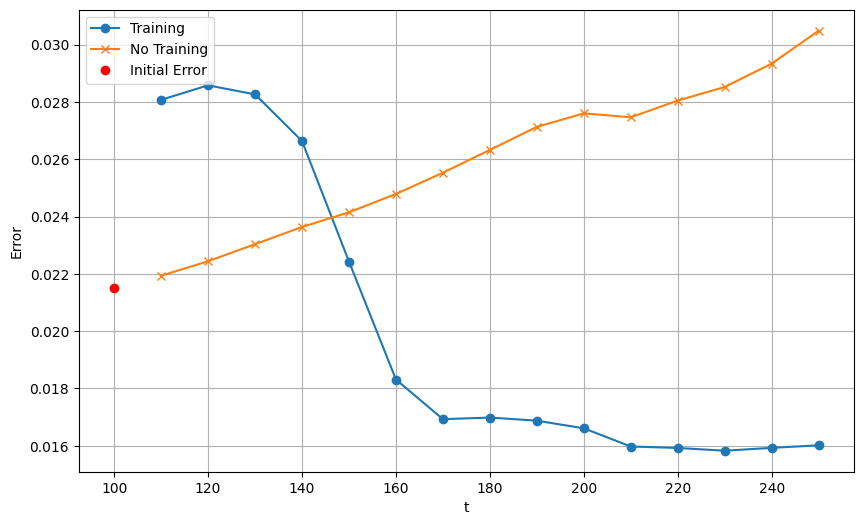

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(t_list, err_1_list, label='Training', marker='o')
plt.plot(t_list, err_2_list, label='No Training', marker='x')
plt.plot([t_pretrain], [initial_error], 'ro', label='Initial Error')
plt.xlabel('t')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()